# Training A Classifier
This is it. You have seen how to define neural networks, complete loss and make updates to the weights of the network.
<br>

#### Now you might be thinking, **What about data**?

Generally, when you have to deal with image, text, audio or video data, you can use standard python packages that loead data into a numpy array. Then you can convert this array into a `torch.*Tensor`.

>* For images, packages such as Pillow, `OpenCV` are useful
>* For audio, packages such as scipy and librosa
>* For text, either raw Python or Cython based loading, or NLTK and SpaCy are useful

Specifically for vision, we have created a package called `torchvision`, that has data loaders for common datasets such as Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz., `torchvision.datasets` and `torch.utils.data.DataLoader`.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR 10 dataset. It have the classes: 'arirplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'. The images in CIFAR-10 are if size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

![cifar-10](https://pytorch.org/tutorials/_images/cifar10.png)

## Training an image classifier
We will do the following steps in order:
1. Load and normalize the CIFAR10 training and test dataset using `torchvision`
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

### 1. Load and normalize CIFAR10
Using `torchvision`, it's extremely easy to load CIFAR10

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0,1]. We transform them to Tensors of normalized range [-1,1].

>* NOTE
<br>
    If running on Windows and you get a BrokenPipeError, try setting the num_worker of torch.utils.data.DataLoader() to 0

In [3]:
transform = transforms.Compose(
[transforms.ToTensor(),
transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root = './data', train = True,
                                        download = True,
                                        transform = transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                         batch_size = batch_size,
                                         shuffle = True,
                                         num_workers = 2)
testset = torchvision.datasets.CIFAR10(root = './data', train = False,
                                      download = True,
                                      transform = transform)
testloader = torch.utils.data.DataLoader(testset,
                                        batch_size = batch_size,
                                        shuffle = False,
                                        num_workers = 2)
classes = ('plane','car','bird','cat','deer','dog',
          'frog','horse','ship','truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
torch.cuda.is_available()

True

Let us show some of the training images, for fun

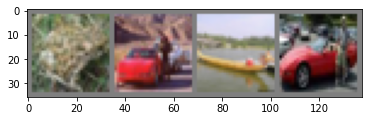

 frog   car  ship   car


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## 2. Define a Convolutional Neural Network
<br>
Copy the neural network from the Neural Networks section before and modify it to take 3-channel images (instead of 1-channel images as it was defined).

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

## 3. Define a Loss function and optimizer
<br>
Let's use a Classification Cross-Entropy loss and SGD with momentum

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

## 4. Train the network
<br>
This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [8]:
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1,
                 running_loss / 2000))
            running_loss = 0.0
print('Finished Training')

C:\Users\Yueqiao\anaconda3\envs\PyTorchEnv\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,  2000] loss: 2.239
[1,  4000] loss: 1.896
[1,  6000] loss: 1.704
[1,  8000] loss: 1.587
[1, 10000] loss: 1.547
[1, 12000] loss: 1.476
[2,  2000] loss: 1.412
[2,  4000] loss: 1.406
[2,  6000] loss: 1.356
[2,  8000] loss: 1.327
[2, 10000] loss: 1.312
[2, 12000] loss: 1.299
Finished Training


Let's quickly save our trained model:

In [9]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html) for more details on saving PyTorch models

## 5. Test the network on the test data
<br>
We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.
<br>
We will check this by predicting the class lable that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.
<br>
Okay, first step. Let us display an image from the test set to get familiar.

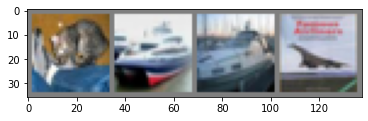

GroundTruth   cat  ship  ship plane


In [10]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth', ' '.join('%5s' % classes[labels[j]]
                             for j in range(4)))

Next, let's load back in our saved model (note: saving and re-loading the model wasn't necessary here, we only did it to illustrate how to do so):

In [11]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:

In [12]:
outputs = net(images)

The outputs are energies (能量) for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let's get the index of the highest energy:

In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                             for j in range(4)))

Predicted:    cat plane  ship plane


The results seem pretty good
<br>
Let use look at how the network performs on the whole dataset

In [14]:
correct = 0
total = 0
# Since we're not training, we don't need to calculate the gradients for our output
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test image: %d %%' % 
     (100 * correct / total))

Accuracy of the network on the 10000 test image: 54 %


That looks way better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.
<br>
<br>
Hmmm, what are the classes that performed well, and the classes that did not perform well:

In [16]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
    
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".
          format(classname, accuracy))

Accuracy for class plane is: 64.0 %
Accuracy for class car   is: 58.4 %
Accuracy for class bird  is: 56.8 %
Accuracy for class cat   is: 38.4 %
Accuracy for class deer  is: 39.8 %
Accuracy for class dog   is: 49.3 %
Accuracy for class frog  is: 59.6 %
Accuracy for class horse is: 59.5 %
Accuracy for class ship  is: 65.9 %
Accuracy for class truck is: 57.8 %


Okay, so what next?
<br>
How do we run these neural networks on the GPU?
<br>
## Training on GPU
Just like how you transfer a Tensor onto the GPU, you transfer the neural net onto the GPU.
<br>
Let's first define our device as the first visible cuda device if we have CUDA available:

In [17]:
torch.cuda.is_available()

True

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [19]:
inputs, labels = data[0].to(device), data[1].to(device)

C:\Users\Yueqiao\anaconda3\envs\PyTorchEnv\lib\site-packages\torch\cuda\__init__.py:106: UserWarning: 
NVIDIA GeForce RTX 3060 Ti with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 compute_37.
If you want to use the NVIDIA GeForce RTX 3060 Ti GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))
